In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
style.use('notebook.mplstyle')

In [3]:
from astropy.table import Table
from astropy import units as u
from astropy import constants as c

In [4]:
from galpy.util import bovy_coords

In [5]:
%%time
t = Table.read('/Users/semyeong/data/gaia/tgas_source/stacked_tgas.fits')

/Users/semyeong/anaconda2/envs/py35/lib/python3.5/site-packages/astropy/units/core.py:1819: UnitsWarning: 'Time[Julian Years]' did not parse as fits unit: At col 0, Unit 'Time' not supported by the FITS standard. 
  warnings.warn(msg, UnitsWarning)

/Users/semyeong/anaconda2/envs/py35/lib/python3.5/site-packages/astropy/units/core.py:1819: UnitsWarning: 'Angle[deg]' did not parse as fits unit: At col 0, Unit 'Angle' not supported by the FITS standard. 
  warnings.warn(msg, UnitsWarning)

/Users/semyeong/anaconda2/envs/py35/lib/python3.5/site-packages/astropy/units/core.py:1819: UnitsWarning: 'Angle[mas]' did not parse as fits unit: At col 0, Unit 'Angle' not supported by the FITS standard. 
  warnings.warn(msg, UnitsWarning)

/Users/semyeong/anaconda2/envs/py35/lib/python3.5/site-packages/astropy/units/core.py:1819: UnitsWarning: 'Angular Velocity[mas/year]' did not parse as fits unit: At col 0, Unit 'Angular' not supported by the FITS standard. 
  warnings.warn(msg, UnitsWarning)

/Us

In [6]:
snparallax = t['parallax']/t['parallax_error']
sncut = snparallax>10

gx,gy,gz = bovy_coords.lbd_to_XYZ(
    deg2rad(t['l'].data), deg2rad(t['b'].data), 1./t['parallax'].data).T

# Nearest neighor distance distribution using physical distance

In [7]:
from sklearn.neighbors import NearestNeighbors

In [10]:
%%time
data_gxyz = vstack([gx, gy, gz]).T
nbrs_gxyz = NearestNeighbors(n_neighbors=128,
                       metric='euclidean').fit(data_gxyz)

CPU times: user 6.37 s, sys: 172 ms, total: 6.54 s
Wall time: 6.63 s


In [11]:
%%time
dist_gxyz, indi_gxyz = nbrs_gxyz.kneighbors(data_gxyz)

CPU times: user 1min 21s, sys: 23.6 s, total: 1min 45s
Wall time: 2min 6s


In [13]:
indi_gxyz.shape

(2057050, 128)

In [10]:
pm1 = vstack([t['pmra'].data,
              t['pmdec'].data]).T
pm2 = vstack([t['pmra'][indi_gxyz[:,1]].data,
              t['pmdec'][indi_gxyz[:,1]].data]).T
sep_deg_gxyz = hypot(t['ra']-t['ra'][indi_gxyz[:,1]], t['dec']-t['dec'][indi_gxyz[:,1]])
sep_pc_gxyz = dist_gxyz[::,1]*1e3
dpm_masyr_gxyz = norm(pm1-pm2, axis=1)
dpm_kms_gxyz = dpm_masyr_gxyz / t['parallax'] * 4.74

## Distribution of nearest neighbor distance in-sky / physical

(-3, 2)

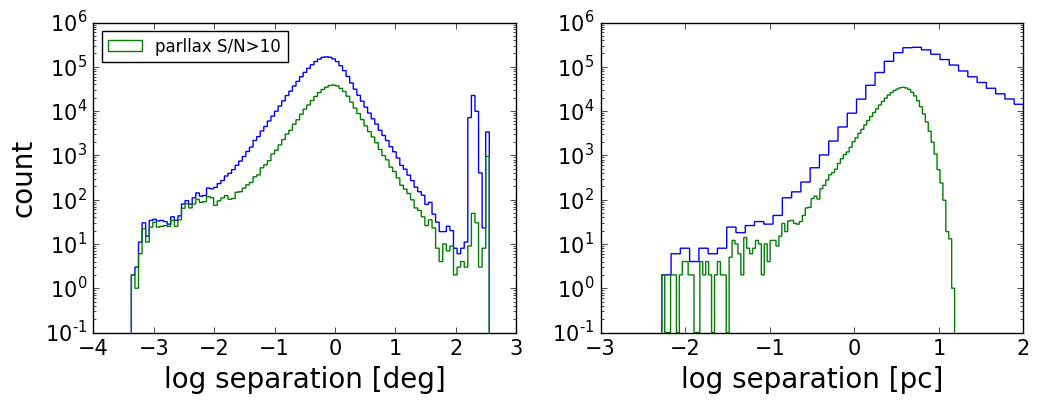

In [14]:
fig, ax = subplots(1, 2, figsize=(12,4))

sca(ax[0])
_= hist(log10(sep_deg_gxyz), 100, log=True, histtype='step')
_= hist(log10(sep_deg_gxyz[sncut]), 100, log=True, histtype='step', label='parllax S/N>10')
xlabel('log separation [deg]')
ylabel('count')
legend(loc='upper left')

sca(ax[1])
_= hist(log10(sep_pc_gxyz), 100, log=True, histtype='step')
_= hist(log10(sep_pc_gxyz[sncut]), 100, log=True, histtype='step')
xlabel('log separation [pc]')
xlim(-3,2)


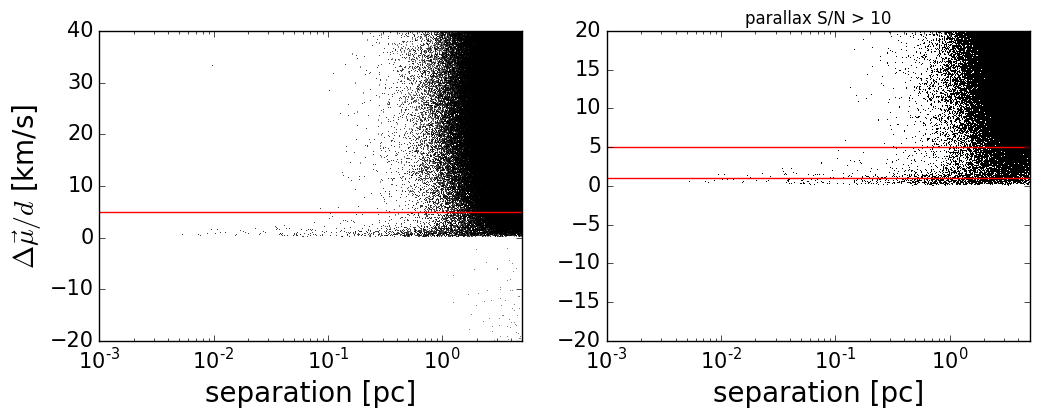

In [20]:
fig, ax = subplots(1, 2, figsize=(12,4))
sca(ax[0])
plot(sep_pc_gxyz, dpm_kms_gxyz, 'k,', alpha=.5)

ylabel(r'$\Delta\vec \mu / d$ [km/s]')
xlabel('separation [pc]')
xscale('log')
xlim(1e-3,5)
ylim(-20,40)
axhline(5, c='r')

sca(ax[1])
plot(sep_pc_gxyz[sncut], dpm_kms_gxyz[sncut], 'k,', alpha=1)
xscale('log')
xlabel('separation [pc]')
xlim(1e-3,5)
ylim(-20,20)
title('parallax S/N > 10')
axhline(5, c='r')
axhline(1, c='r')

In [18]:
print sum((dpm_kms_gxyz < 5) & sncut)
print sum((dpm_kms_gxyz < 1) & sncut)

10948
2039


# Distribution of separation with a cut on $\Delta\vec \mu / d$

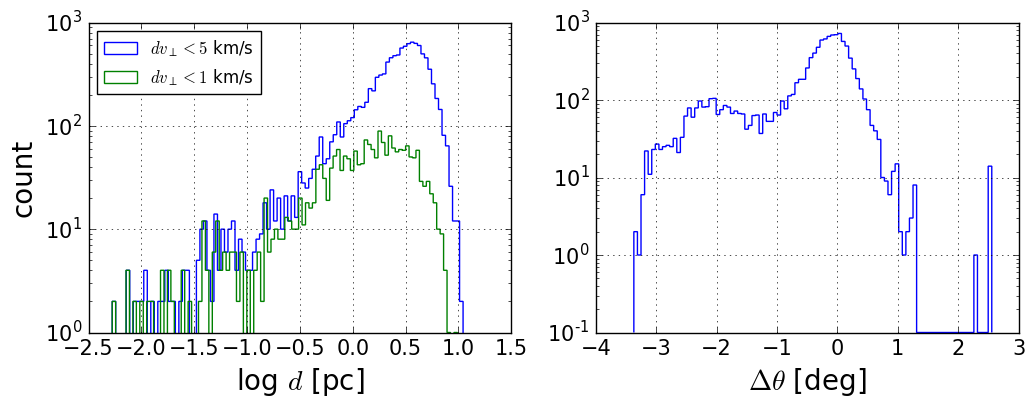

In [19]:
fig, ax = subplots(1, 2, figsize=(12,4))
sca(ax[0])
hist(log10(sep_pc_gxyz[(dpm_kms_gxyz<5)& sncut]), 100, log=True, histtype='step', label='$dv_\perp<5$ km/s')
hist(log10(sep_pc_gxyz[(dpm_kms_gxyz<1)& sncut]), 100, log=True, histtype='step', label='$dv_\perp<1$ km/s')
ylabel('count')
xlabel(r'log $d$ [pc]')
grid()
legend(loc='upper left')
ylim(1)

sca(ax[1])
hist(log10(sep_deg_gxyz[(dpm_kms_gxyz<5)& sncut]), 100, log=True, histtype='step')
# yscale('log')
xlabel(r'$\Delta \theta$ [deg]')
grid()
# xlim(1.5,5.5)

# Location on sky for common proper motion pairs

(-90, 90)

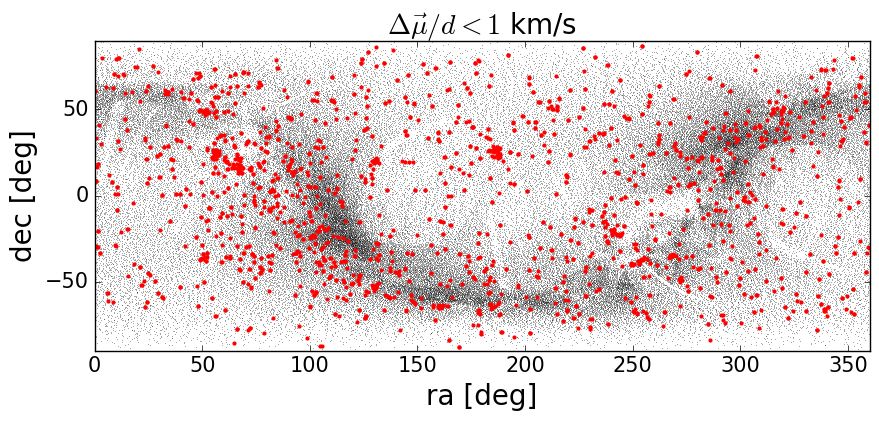

In [25]:
close_in_pm = (dpm_kms_gxyz<1) & sncut

figure(figsize=(10,4))
title(r'$\Delta\vec\mu/d < 1$ km/s', size=20)
plot(t['ra'][::20], t['dec'][::20], 'k,', alpha=.35)
# scatter(t['ra'][close_in_pm], t['dec'][close_in_pm], c=log10(sep_pc_gxyz[close_in_pm]), cmap='magma')
plot(t['ra'][close_in_pm], t['dec'][close_in_pm], 'r.')
xlabel('ra [deg]')
ylabel('dec [deg]')
xlim(0,360)
ylim(-90,90)
# colorbar()

(-90, 90)

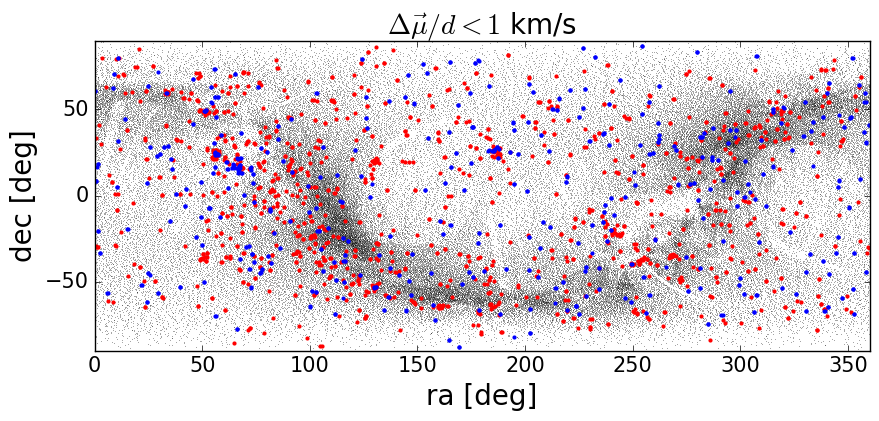

In [32]:
close_in_pm_ssep = (dpm_kms_gxyz<1) & sncut & (sep_pc_gxyz<1.)
close_in_pm_lsep = (dpm_kms_gxyz<1) & sncut & (sep_pc_gxyz>1.)

figure(figsize=(10,4))
title(r'$\Delta\vec\mu/d < 1$ km/s', size=20)
plot(t['ra'][::20], t['dec'][::20], 'k,', alpha=.35)
plot(t['ra'][close_in_pm_lsep], t['dec'][close_in_pm_lsep], 'r.', label='sep > 1pc')
plot(t['ra'][close_in_pm_ssep], t['dec'][close_in_pm_ssep], 'b.', label='sep < 1pc')
xlabel('ra [deg]')
ylabel('dec [deg]')
xlim(0,360)
ylim(-90,90)

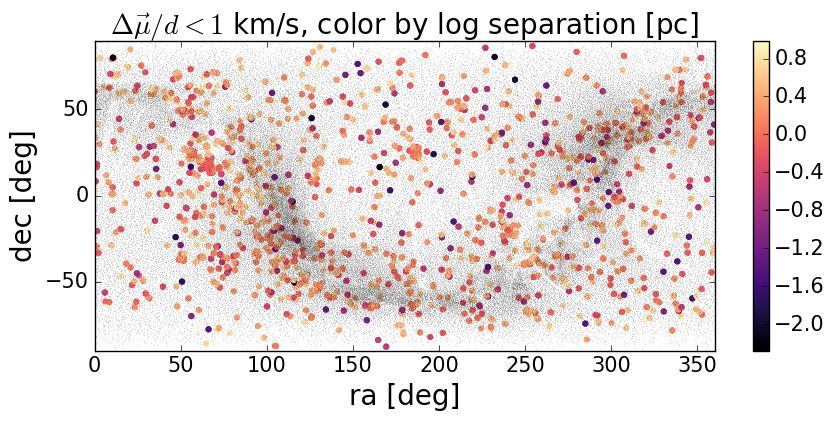

In [38]:
close_in_pm = (dpm_kms_gxyz<1) & sncut

figure(figsize=(10,4))
title(r'$\Delta\vec\mu/d < 1$ km/s, color by log separation [pc]', size=20)
plot(t['ra'][::20], t['dec'][::20], 'k,', alpha=.15)
scatter(t['ra'][close_in_pm], t['dec'][close_in_pm], c=log10(sep_pc_gxyz[close_in_pm]), cmap='magma')
# plot(t['ra'][close_in_pm], t['dec'][close_in_pm], 'r.')
xlabel('ra [deg]')
ylabel('dec [deg]')
xlim(0,360)
ylim(-90,90)
colorbar()